In [169]:
import cobra
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
sys.path.append('../../code/')
import leakage
from pathlib import Path
import matplotlib
import seaborn as sns
from scipy.stats import mannwhitneyu

# Load model

In [124]:
model = cobra.io.read_sbml_model('../../models/e_coli/momentiJO1366.xml')

In [120]:
model.reactions.DHAPT.knock_out()
model.reactions.THRA.knock_out()
model.reactions.THRA2.knock_out()
model.reactions.F6PA_TG_forward.knock_out()

# Speculations
model.reactions.PFL.knock_out()

## Define environment

In [121]:
model.reactions.EX_glc__D_e.lower_bound = -10
for r in model.exchanges:
    r.upper_bound = 1000

In [125]:
print(model.optimize())
print(model.summary())

<Solution 0.743 at 0x7f8f88908d30>
Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.7429753865197879

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e  0.003867         0   0.00%
      cl_e      EX_cl_e  0.003867         0   0.00%
 cobalt2_e EX_cobalt2_e 1.857E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0005268         0   0.00%
     fe2_e     EX_fe2_e   0.01193         0   0.00%
  glc__D_e  EX_glc__D_e     13.83         6 100.00%
       k_e       EX_k_e     0.145         0   0.00%
     mg2_e     EX_mg2_e  0.006445         0   0.00%
     mn2_e     EX_mn2_e 0.0005134         0   0.00%
    mobd_e    EX_mobd_e 9.584E-05         0   0.00%
     nh4_e     EX_nh4_e     8.025         0   0.00%
     ni2_e     EX_ni2_e   0.00024         0   0.00%
      o2_e      EX_o2_e     16.25         0   0.00%
      pi_e      EX_pi_e    0.7167         0   0.00%
     so4_e     EX_so4_e    0.1874         0   0.00%


# Get leakage


In [90]:
exometabolites_folder = Path("../../data/e_coli/")
leakage_df = leakage.get_leakage(exometabolites_folder, "ecoli", time = 7)
leakage_df.set_index("Metabolite", inplace=True)
leakage_df.drop_duplicates(inplace=True)

In [91]:
leakage_df

,Leakage (uM/h/OD),Leakage std
Metabolite,,
G6P,0.440616,0.015430
F6P,0.718007,0.033832
FBP,0.359004,0.014058
DHAP,0.627496,0.065091
GA3P,0.186804,0.014218
23PG,0.254953,0.023705
PEP,0.069823,0.006347
R5P,0.092261,0.004086
RU5P+X5P,0.041445,0.003663


In [92]:
# Read metabolite mapping
mapping_df = pd.read_csv('../../data/e_coli/abbrev_to_id.csv', index_col=0)
leakage_df = leakage_df.join(mapping_df)


In [93]:
leakage_df.set_index('met id', inplace = True)

# Plot a cumulative distribution of shadow prices


In [94]:
solution = model.optimize()

In [95]:
turnover_dict = {}
for m in model.metabolites:
    if m.compartment == 'c':
        total_flux = 0
        for r in m.reactions:
            flux_r = solution.fluxes[r.id]*r.get_coefficient(m.id)
            if flux_r > 0:
                total_flux += flux_r
        turnover_dict[m.id] = total_flux

In [96]:
sp = solution.shadow_prices

In [97]:
sp.sort_values(inplace=True)

In [98]:
# Filter metabolites to only the organic metabolites where there is a turnover
met_ids =[]
sp_list = []
for m in model.metabolites:
    # Remove non-organic compounds
    if m.id[:-2].lower() in ['co2', 'hco3']:
        continue
    if m.compartment == 'c':
        if sp[m.id] <0:
            if turnover_dict[m.id] >0:
                if 'C' in m.elements.keys():
                    met_ids.append(m.id)
                    sp_list.append(sp[m.id])

In [99]:
selected_sp = pd.Series(sp_list, index = met_ids)

In [100]:
selected_sp.sort_values(inplace = True, ascending=False)

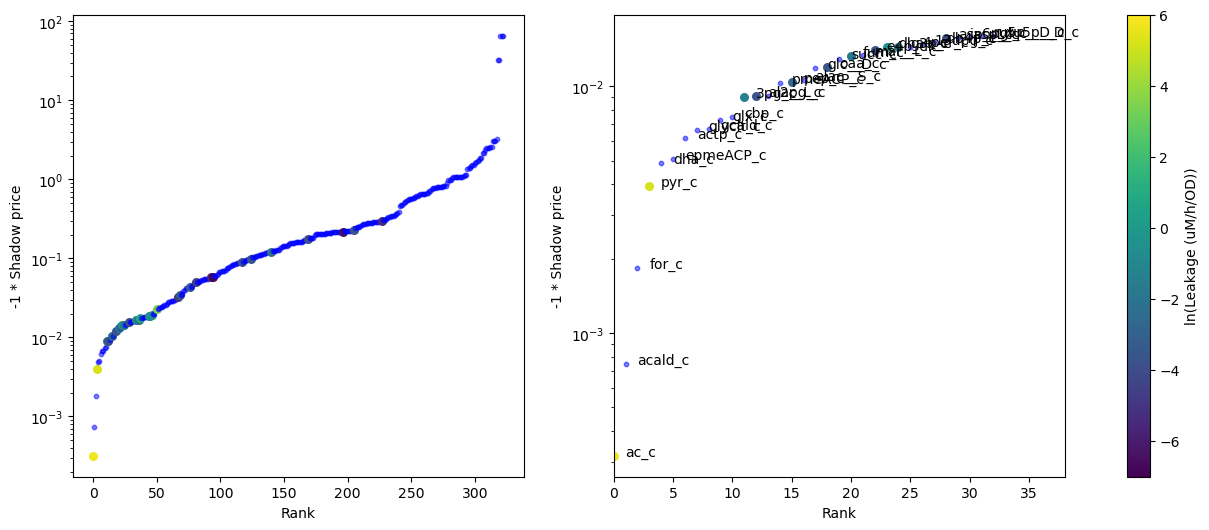

In [101]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (16,6))
smax = np.log(leakage_df['Leakage (uM/h/OD)'].abs().max())
smin = np.log(leakage_df['Leakage (uM/h/OD)'].abs().min())
norm = plt.Normalize(vmin=np.floor(smin), vmax=np.ceil(smax))
#norm = matplotlib.colors.BoundaryNorm([0,1,2,3], cmap.N, extend='neither')
cmap = plt.cm.viridis
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)


# Get 10% least valuable
first_x = np.ceil(0.1*len(selected_sp))

for i, (m_id, sp_i) in enumerate(selected_sp.items()):
    met_id = m_id.replace('_c', '')
    try:
        leak_i = leakage_df.loc[met_id, "Leakage (uM/h/OD)"]
    except KeyError:
        leak_i = 0 
    if sp_i > 0:
        raise ValueError
    sp_abs = np.abs(sp_i)
    
    if leak_i > 0:
        ax1.scatter(i, sp_abs, s = 30, c = np.log(leak_i), cmap = cmap, norm = norm)
    else:
        ax1.scatter(i, sp_abs,s=10, c = 'b', alpha = 0.5)
    
    # Make a seperate plot for the 10% least expensive
    if i < first_x:
        if leak_i > 0:
            ax2.scatter(i, sp_abs, s = 30, c = np.log(leak_i), cmap = cmap, norm = norm)
        else:
            ax2.scatter(i, sp_abs,s=10, c = 'b', alpha = 0.5)
        ax2.annotate(m_id, (i+1, sp_abs))

    
    
#ax.scatter(np.arange(len(selected_sp)), np.abs(selected_sp), s = 10)
ax1.set_yscale('log')
#ax1.set_xlim(0,400)
ax2.set_yscale('log')
ax2.set_xlim(0, first_x+5)
ax1.set_ylabel('-1 * Shadow price')
ax2.set_ylabel('-1 * Shadow price')
ax1.set_xlabel('Rank')
ax2.set_xlabel('Rank')

fig.colorbar(sm, ax = [ax1, ax2], label = "ln(Leakage (uM/h/OD))")
# plt.savefig('Rank of shadow price ecoli knock outs.svg')

In [158]:
leakage_df

,Leakage (uM/h/OD),Leakage std
met id,,
g6p,0.440616,0.015430
f6p,0.718007,0.033832
fdp,0.359004,0.014058
dhap,0.627496,0.065091
g3p,0.186804,0.014218
3pg,0.254953,0.023705
pep,0.069823,0.006347
r5p,0.092261,0.004086
"ru5p__D, ru5p__L, xu5p__D, xu5p__L",0.041445,0.003663


# Violin plot of distributions


<AxesSubplot:xlabel='Data', ylabel='ln(-Shadow price)'>

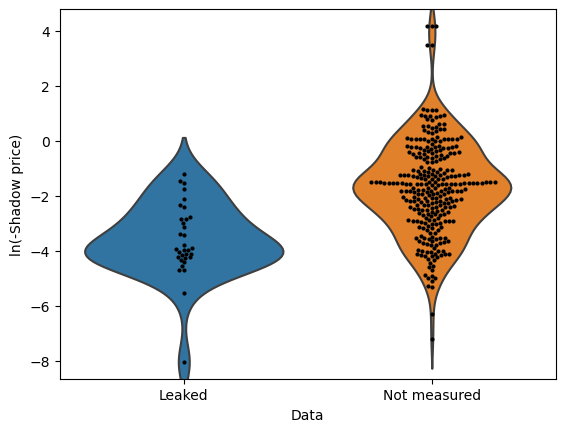

In [168]:
leaked = []
not_measured = []
df_violin = pd.DataFrame()
df_violin['ln(-Shadow price)'] = np.log(selected_sp*-1)

for i, (m_id, sp_i) in enumerate(selected_sp.items()):
    met_id = m_id.replace('_c', '')
    try:
        leak_i = leakage_df.loc[met_id, "Leakage (uM/h/OD)"]
    except KeyError:
        leaked.append("Not measured")
    else:
        leaked.append("Leaked")
df_violin["Data"] = leaked

        
# df_sp = pd.DataFrame({'Leaked':leaked, 'Not measured': not_measured})
# fig, ax = plt.subplots(1, figsize = (8,8))
g = sns.violinplot(data = df_violin, x = "Data", y = 'ln(-Shadow price)', inner = None)
sns.swarmplot(data=df_violin, x = "Data", y = 'ln(-Shadow price)', color="k", size=3, ax=g.axes)
#sns.violinplot(data=df_sp, x="age", y="class")



# Significant difference?
Now performing a mannwhitneyu, but need to chjeck whether this is appropriate

In [172]:
x = df_violin.loc[df_violin['Data']== 'Leaked', 'ln(-Shadow price)']
y = df_violin.loc[df_violin['Data']== 'Not measured', 'ln(-Shadow price)']
mannwhitneyu(x,y)

MannwhitneyuResult(statistic=1741.0, pvalue=2.132728712059194e-09)

In [167]:
g.axes

<AxesSubplot:xlabel='Data', ylabel='ln(-Shadow price)'>

In [151]:
df_violin

,Shadow price,Data
ac_c,-0.000319,Leaked
acald_c,-0.000747,Leaked
for_c,-0.001828,Leaked
pyr_c,-0.003938,Leaked
dha_c,-0.004902,Leaked
...,...,...
moco_c,-32.595900,Leaked
mptamp_c,-32.799671,Leaked
bmoco_c,-65.186376,Leaked
bmoco1gdp_c,-65.391201,Leaked


Signature: selected_sp.to_frame(name: 'Hashable' = <no_default>) -> 'DataFrame'
Docstring:
Convert Series to DataFrame.

Parameters
----------
name : object, optional
    The passed name should substitute for the series name (if it has
    one).

Returns
-------
DataFrame
    DataFrame representation of Series.

Examples
--------
>>> s = pd.Series(["a", "b", "c"],
...               name="vals")
>>> s.to_frame()
  vals
0    a
1    b
2    c
File:      ~/opt/anaconda3/envs/pytfa/lib/python3.10/site-packages/pandas/core/series.py
Type:      method

In [87]:
print(selected_sp[:int(first_x)])

ac_c        -0.000364
pyr_c       -0.004247
epmeACP_c   -0.004632
actp_c      -0.005998
glyclt_c    -0.006232
gcald_c     -0.006520
glx_c       -0.006521
cbp_c       -0.007253
ala__L_c    -0.008109
pmeACP_c    -0.008468
3pg_c       -0.009243
2pg_c       -0.009358
pep_c       -0.010525
3php_c      -0.010768
glc__D_c    -0.010783
oaa_c       -0.010820
alac__S_c   -0.010858
fum_c       -0.012259
succ_c      -0.012325
mal__L_c    -0.012407
iasp_c      -0.013112
asp__L_c    -0.013306
pimACP_c    -0.014006
dhap_c      -0.014607
g3p_c       -0.014611
13dpg_c     -0.014839
6pgl_c      -0.015618
ala_B_c     -0.015666
e4p_c       -0.016056
xu5p__D_c   -0.016091
akg_c       -0.016093
4per_c      -0.016223
cit_c       -0.016288
dtype: float64


# Check if metabolites are dispensable

In [141]:
with model as model:
    print(model.slim_optimize())
    model.metabolites.glyclt_c.remove_from_model(destructive = True)
    print(model.slim_optimize())

0.7429753865197872
0.0


In [ ]:
model.metabolites.glc__D_c.remove_from_model()

In [105]:
model.metabolites.actp_c

Metabolite identifier,actp_c
Name,Acetyl phosphate
Memory address,0x7f8fd8956890
Formula,C2H3O5P
Compartment,c
In 4 reaction(s),"ACKr_TG_forward, PTAr_TG_reverse, PTAr_TG_forward, ACKr_TG_reverse"


In [104]:
model.reactions.THRA.name


'Threonine aldolase'

In [65]:
sp_neg = [x for x in sp_list if x < 0]
sp_pos = [x for x in sp_list if x > 0]

In [66]:
sp_neg = sorted(sp_neg)
sp_pos = sorted(sp_pos)

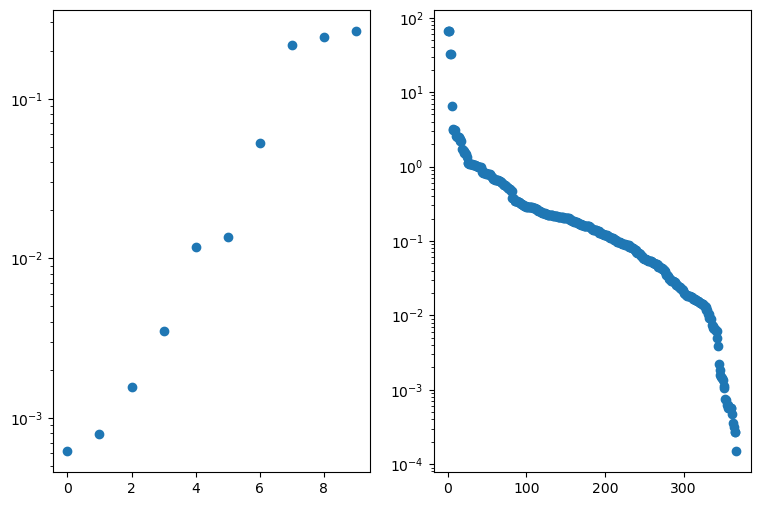

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 6))
ax1.scatter(np.arange(len(sp_pos)), sp_pos)
ax1.set_yscale('log')
ax2.scatter(np.arange(len(sp_neg)), np.abs(sp_neg))
ax2.set_yscale('log')